In [1]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from scipy.stats import normaltest, shapiro
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)
pd.set_option("display.max_colwidth", 200)

In [2]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

For reference: https://nbviewer.jupyter.org/github/IncioMan/socialdata/blob/master/FinalProject/TrafficDataProject.ipynb

### Import

In [3]:
methods = ["dataset1", "dataset2"]

In [4]:
direct_and_pr = pd.read_csv(f"{csv_folder}/final_datasets/{methods[0]}_with_sw_metrics.csv", index_col=0)

In [5]:
iterative_pr_head_ref_cherry_picked = pd.read_csv(f"{csv_folder}/final_datasets/{methods[1]}_with_sw_metrics.csv", index_col=0)

In [6]:
methods_df = {"dataset1":direct_and_pr,
             "dataset2": iterative_pr_head_ref_cherry_picked}

### Features

| Variable name                            | Variable description                                                                                               | Variable type | How many      |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------|---------------|
| ratio_{state}_build                      | Ratio number of builds in the state over all builds for the release                                                | Continuous    | 4             |
| ratio_pr_build                           | Ratio number of pull request builds in the state over all builds for the release                                   | Continuous    | 1             |
| {aggr}_{state}_build_duration            | Aggregation for the duration of the builds in that state for the release                                           | Continuous    | 4 \* 3 = 12   |
| {aggr}\_n\_builds_per_pull_request       | Aggregation of the number of builds per pull request for the release                                               | Continuous    | 4             |
| {aggr}_failed_tests                      | Aggregation of the number failed tests per build for the release                                                   | Continuous    | 4             |
| {aggr}_errors_over_tests_total           | Aggregation of the number of error words over the tests run per build for the release                              | Continuous    | 4             |
| {aggr}_failures_over_tests_total         | Aggregation of the number of failures words over the tests run per build for the release                           | Continuous    | 4             |
| {aggr}_skipped_over_tests_total          | Aggregation of the number of skipped words over the tests run per build for the release                            | Continuous    | 4             |
| {aggr}\_n\_exceptions                    | Aggregation of the number of thrown exceptions per build for the release                                           | Continuous    | 4             |
| {aggr}\_n\_warnings                      | Aggregation of the number of warning words per build for the release                                               | Continuous    | 4             |
| {aggr}\_n\_error_classes                 | Aggregation of the number of error classes thrown per build for the release                                        | Continuous    | 4             |
| {state}\_gp{x}\_bs{y}\_n\_bursts_{aggr}  | Aggregation over number of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y    | Continuous    | 3 \*9 \*4=108 |
| {state}\_gp{x}\_bs{y}\_burst_size_{aggr} | Aggregation over the sizes of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y | Continuous    | 3 \*9 \*4=108 |
|                                          |                                                                                                                    |               | Total = 265   |

Remove unwanted features

In [7]:
for method in methods:
    methods_df[method] = methods_df[method].drop(columns=["ratio_pr_builds_failed"])

**Size**

In [8]:
for method in methods:
    print(methods_df[method].shape)

(52, 300)
(52, 300)


**Number burst metrics**

In [9]:
for method in methods:
    print(len([x for x in methods_df[method].columns if "burst" in x]))

216
216


**Number non burst metrics**

In [10]:
for method in methods:
    print(len([x for x in methods_df[method].columns if not "burst" in x]))

84
84


**Masks fo java build tool**

In [11]:
for method, df in methods_df.items():
    gradle_mask = df.java_build_tool == "gradle"
    print("Gradle", gradle_mask.sum())
    maven_mask = df.java_build_tool == "maven"
    print("Maven", maven_mask.sum())

Gradle 20
Maven 32
Gradle 20
Maven 32


In [12]:
all_mask = [True]*len(methods_df[methods[0]])

In [13]:
mask_name = "gradle"
mask_to_use = gradle_mask

**Extracting the dependent variables** 

In [14]:
dep_var_cols = ["java_build_tool","post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]

In [15]:
methods_dep_var = {}
for method in methods:
    methods_dep_var[method] = methods_df[method]\
    [dep_var_cols]
    methods_dep_var[method] = methods_dep_var[method][mask_to_use]

**Extracting the independent variables**

In [16]:
extra_info_cols = ['version_name','from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag', "java_build_tool"]

In [17]:
pre_release_bugs_columns = ["pre_release_bugs"]

In [18]:
methods_indep_var = {}
for method in methods:
    methods_indep_var[method] = methods_df[method].drop(columns=extra_info_cols + pre_release_bugs_columns + dep_var_cols)
    methods_indep_var[method] = methods_indep_var[method][mask_to_use]
    print(method, methods_indep_var[method].shape)

dataset1 (20, 277)
dataset2 (20, 277)


### Missing values

In [19]:
methods_indep_var[methods[0]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [20]:
methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [21]:
df = methods_indep_var[methods[0]]
df[df.min_failed_build_duration.isna()]

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,min_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,min_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,min_n_error_classes,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,...,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min,mean_skipped_tests,median_skipped_tests,max_skipped_tests,min_skipped_tests,mean_total_tests,median_total_tests,max_total_tests,min_total_tests,mean_passed_tests,median_passed_tests,max_passed_tests,min_passed_tests
34,1.000000,0.0,0.0,0.000000,0.0,1343.090909,1339.0,1529.0,1146.0,NaN,NaN,NaN,NaN,1343.090909,1339.0,1529.0,1146.0,0.0,0.0,0,0,1.501101,1.501109,3.0,0.002188,0.0,0.0,0.0,0.0,2.001101,2.001109,4.0,0.002188,0.000367,0.000365,0.00074,0.000000,0.000000,0.0,0,0,19.000000,19.0,22.0,16.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,2.0,4.0,0.0,681.000000,675.5,1370.0,0.0,679.000000,673.5,1366.0,0.0
40,0.000000,0.0,0.0,1.000000,0.0,NaN,NaN,NaN,NaN,

If we look at the ratio of builds in the state, we see that both datasets have missing values for duration due to no builds in that state being associated with that release.
We replace the values with 0.

In [22]:
for method in methods:
    methods_indep_var[method].fillna(0, inplace=True)

In [23]:
len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0])\
+ len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[0]].isna().sum()>0])

0

### Drop columns with no information

In [24]:
method_uninformative_columns = {}
for method in methods:
    df = methods_indep_var[method]
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    method_uninformative_columns[method] = cols_to_drop
    methods_indep_var[method] = df.drop(cols_to_drop, axis=1)
    print(method, methods_indep_var[method].shape)

dataset1 (20, 245)
dataset2 (20, 245)


In [25]:
method_uninformative_columns[methods[0]].nunique()

32

In [26]:
set(method_uninformative_columns[methods[0]]).difference(set(method_uninformative_columns[methods[1]]))

set()

In [27]:
set(method_uninformative_columns[methods[1]]).difference(set(method_uninformative_columns[methods[0]]))

set()

### Statistical summary

**Method 0**

Not burst metrics

In [28]:
methods_indep_var[methods[1]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,max_n_error_classes,mean_skipped_tests,median_skipped_tests,max_skipped_tests,mean_total_tests,median_total_tests,max_total_tests,min_total_tests,mean_passed_tests,median_passed_tests,max_passed_tests,min_passed_tests
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.00000,20.00000,20.00000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.818085,0.001744,0.102484,0.077687,0.002633,2013.783049,2060.875000,2644.50000,1216.850000,613.086131,602.425000,821.750000,448.100000,2013.872638,2032.200000,2572.750000,1455.85000,0.15000,0.15000,0.15000,0.15000,12.682869,10.450704,35.971429,0.001950,0.514971,0.025000,5.450000,2.100155,1.119713,9.328571,0.000782,7.863292,6.175296,19.064307,0.000092,2.004758,0.300000,25.350000,22.081783,16.15000,116.600000,4.250000,0.024721,0.900000,0.869143,0.500000,3.200000,1015.336746,810.275000,3530.550000,0.300000,1013.952632,807.925000,3527.800000,0.300000
std,0.239432,0.007800,0.142475,0.130967,0.008167,535.524808,521.084695,694.88511,841.350185,615.165600,620.589687,834.053695,558.293726,671.032779,674.008109,876.655419,793.39207,0.48936,0.48936,0.48936,0.48936,20.540653,20.107423,54.742608,0.001126,1.338540,0.111803,9.225109,1.090940,1.117421,6.697082,0.000481,9.696453,9.554770,24.540068,0.000189,2.657498,0.376969,42.282602,10.832010,8.83191,220.375851,5.910517,0.078326,2.468752,0.902057,0.858395,5.156498,176.894979,487.494412,4057.007005,1.341641,177.222429,486.439867,4056.615527,1.341641
min,0.000000,0.000000,0.000000,0.000000,0.000000,1134.112903,1216.000000,1435.00000,178.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.189822,0.001787,0.428571,0.000000,0.000000,0.000000,0.000000,0.264326,0.000456,1.000000,0.000000,0.000117,0.000000,0.000468,0.000000,0.000000,0.000000,0.000000,9.088235,6.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,661.263158,0.000000,1351.000000,0.000000,659.263158,0.000000,1347.000000,0.000000
25%,0.777083,0.000000,0.000000,0.000000,0.000000,1612.817167,1748.750000,2358.25000,368.250000,0.000000,0.000000,0.000000,0.000000,1756.107742,1885.000000,2358.250000,1172.25000,0.00000,0.00000,0.00000,0.00000,1.124636,0.153481,3.000000,0.001340,0.000000,0.000000,0.000000,1.560970,0.023741,4.750000,0.000445,0.005300,0.000464,0.142869,0.000000,0.509615,0.000000,2.000000,13.453125,10.50000,34.750000,0.000000,0.000000,0.00

In [29]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,max_n_error_classes,mean_skipped_tests,median_skipped_tests,max_skipped_tests,mean_total_tests,median_total_tests,max_total_tests,min_total_tests,mean_passed_tests,median_passed_tests,max_passed_tests,min_passed_tests
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.00000,20.00000,20.00000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.817032,0.001744,0.077648,0.103576,0.002678,1962.250477,2004.850000,2572.750000,1188.650000,542.866369,538.725000,750.000000,376.950000,2034.192100,2047.550000,2572.750000,1530.50000,0.15000,0.15000,0.15000,0.15000,12.787756,10.662762,35.971429,0.002031,0.765439,0.525000,5.450000,2.128430,1.240361,9.328571,0.001994,7.872915,6.225257,19.050207,0.000093,2.112913,1.350000,13.700000,20.329359,16.600000,44.450000,5.900000,0.001603,0.100000,0.855513,0.425000,3.15000,958.197221,760.425000,2096.950000,0.300000,956.576269,758.075000,2093.000000,0.300000
std,0.239211,0.007800,0.108938,0.227928,0.008321,704.429177,695.550938,876.655419,919.319673,598.304216,602.498689,840.222464,515.287909,683.194697,684.750125,876.655419,781.97641,0.48936,0.48936,0.48936,0.48936,20.616800,20.126634,54.742608,0.001167,2.380114,2.347871,9.225109,1.070904,1.083114,6.697082,0.005087,9.703000,9.545427,24.551548,0.000190,4.634655,4.642765,19.021041,8.952062,9.794735,23.959341,7.859958,0.007167,0.447214,0.918101,0.674244,5.18373,206.759170,481.940739,744.848517,1.341641,207.880097,480.914925,742.512874,1.341641
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.189822,0.001787,0.428571,0.000000,0.000000,0.000000,0.000000,0.511737,0.000456,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.500000,6.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,638.500000,0.000000,1277.000000,0.000000,628.000000,0.000000,1256.000000,0.000000
25%,0.775641,0.000000,0.000000,0.000000,0.000000,1612.817167,1748.750000,2358.250000,307.500000,0.000000,0.000000,0.000000,0.000000,1756.107742,1885.000000,2358.250000,1172.25000,0.00000,0.00000,0.00000,0.00000,1.125362,0.857842,3.000000,0.001340,0.000000,0.000000,0.000000,1.571177,0.023741,4.750000,0.000445,0.000420,0.000377,0.001118,0.000000,0.496429,0.000000,1.750000,13.453125,9.000000,28.750000,0.000000,0.000000,0.000000,0.281250

Our features are all continuous:
* Because of their nature we know they should not present negative values and indeed they do not
* Ratio features should range between 0 and 1: they correctly do
* Min_all_build_duration presents negative values: this is due to erros in the build dataset (fixed)

Burst metrics

In [30]:
methods_indep_var[methods[0]].shape

(20, 245)

In [31]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[0]].columns if "burst" in x]].describe()

,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,not_passed_gp1_bs2_burst_size_mean,not_passed_gp1_bs2_burst_size_median,not_passed_gp1_bs2_burst_size_max,not_passed_gp1_bs3_n_bursts_mean,not_passed_gp1_bs3_n_bursts_median,not_passed_gp1_bs3_n_bursts_max,not_passed_gp1_bs3_n_bursts_min,not_passed_gp1_bs3_burst_size_mean,not_passed_gp1_bs3_burst_size_median,not_passed_gp1_bs3_burst_size_max,not_passed_gp2_bs1_n_bursts_mean,not_passed_gp2_bs1_n_bursts_median,not_passed_gp2_bs1_n_bursts_max,not_passed_gp2_bs1_n_bursts_min,not_passed_gp2_bs1_burst_size_mean,not_passed_gp2_bs1_burst_size_median,not_passed_gp2_bs1_burst_size_max,not_passed_gp2_bs2_n_bursts_mean,not_passed_gp2_bs2_n_bursts_median,not_passed_gp2_bs2_n_bursts_max,not_passed_gp2_bs2_n_bursts_min,not_passed_gp2_bs2_burst_size_mean,not_passed_gp2_bs2_burst_size_median,not_passed_gp2_bs2_burst_size_max,not_passed_gp2_bs3_n_bursts_mean,not_passed_gp2_bs3_n_bursts_median,not_passed_gp2_bs3_n_bursts_max,not_passed_gp2_bs3_n_bursts_min,not_passed_gp2_bs3_burst_size_mean,not_passed_gp2_bs3_burst_size_median,not_passed_gp2_bs3_burst_size_max,not_passed_gp3_bs1_n_bursts_mean,not_passed_gp3_bs1_n_bursts_median,not_passed_gp3_bs1_n_bursts_max,not_passed_gp3_bs1_n_bursts_min,not_passed_gp3_bs1_burst_size_mean,not_passed_gp3_bs1_burst_size_median,not_passed_gp3_bs1_burst_size_max,not_passed_gp3_bs2_n_bursts_mean,not_passed_gp3_bs2_n_bursts_median,not_passed_gp3_bs2_n_bursts_max,not_passed_gp3_bs2_n_bursts_min,not_passed_gp3_bs2_burst_size_mean,not_passed_gp3_bs2_burst_size_median,not_passed_gp3_bs2_burst_size_max,not_passed_gp3_bs3_n_bursts_mean,not_passed_gp3_bs3_n_bursts_median,not_passed_gp3_bs3_n_bursts_max,not_passed_gp3_bs3_n_bursts_min,...,failed_gp1_bs1_n_bursts_min,failed_gp1_bs1_burst_size_mean,failed_gp1_bs1_burst_size_median,failed_gp1_bs1_burst_size_max,failed_gp1_bs2_n_bursts_mean,failed_gp1_bs2_n_bursts_median,failed_gp1_bs2_n_bursts_max,failed_gp1_bs2_n_bursts_min,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.

Burst metrics should all be positive and they indeed are

### Perfectly correlated features

In [32]:
methods_fully_correlated_features = {}
for method in methods:
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_fully_correlated_features[method] = sol[sol > 0.999]

In [33]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    for pair in methods_fully_correlated_features[method].index:
        if((pair[1] in cols_to_remove) or (pair[0] in cols_to_remove)):
            continue
        else:
            cols_to_remove.add(pair[0])
    methods_corr_cols_to_remove[method] = cols_to_remove
    print(method, len(cols_to_remove))

dataset1 165
dataset2 160


**How many columns to remove due to perfect correlation are burst metric?**

In [34]:
for method in methods:
    print(method, len([col for col in methods_corr_cols_to_remove[method] if "burst" in col])\
          /len(methods_corr_cols_to_remove[method]))

dataset1 0.9454545454545454
dataset2 0.95625


There are a couple not burst features

In [35]:
[col for col in methods_corr_cols_to_remove[methods[0]] if  not "burst" in col]

['mean_n_error_classes',
 'max_n_builds_per_pull_request',
 'max_total_tests',
 'median_n_builds_per_pull_request',
 'median_total_tests',
 'min_total_tests',
 'mean_n_builds_per_pull_request',
 'mean_total_tests',
 'max_not_errored_or_canceled_build_duration']

In [36]:
[col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]

['max_n_builds_per_pull_request',
 'max_total_tests',
 'median_n_builds_per_pull_request',
 'median_total_tests',
 'min_total_tests',
 'mean_n_builds_per_pull_request',
 'mean_total_tests']

In [37]:
for col in [col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]:
    x = methods_fully_correlated_features[methods[1]]
    print(col,":\n", x[col])

max_n_builds_per_pull_request :
 min_n_builds_per_pull_request    1.0
dtype: float64
max_total_tests :
 max_passed_tests    1.0
dtype: float64
median_n_builds_per_pull_request :
 min_n_builds_per_pull_request    1.0
max_n_builds_per_pull_request    1.0
dtype: float64
median_total_tests :
 median_passed_tests    1.0
dtype: float64
min_total_tests :
 min_passed_tests    1.0
dtype: float64
mean_n_builds_per_pull_request :
 min_n_builds_per_pull_request       1.0
max_n_builds_per_pull_request       1.0
median_n_builds_per_pull_request    1.0
dtype: float64
mean_total_tests :
 mean_passed_tests    1.0
dtype: float64


Remove the perfectly correlated columns

In [38]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(20, 80)
(20, 85)


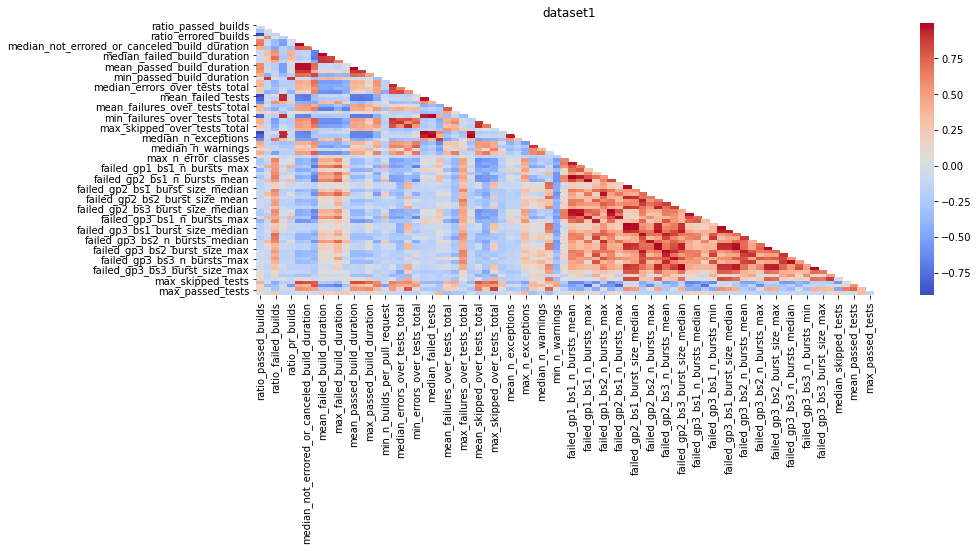

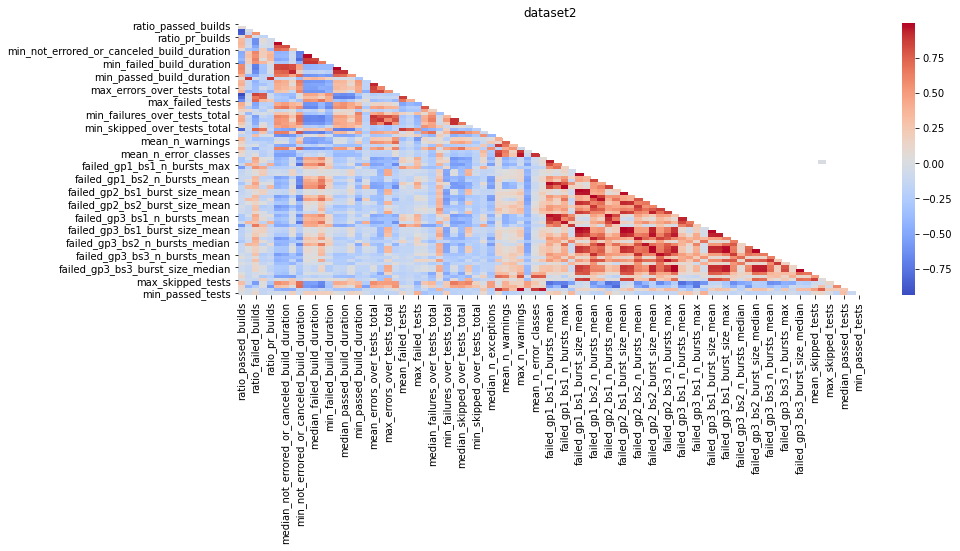

In [39]:
for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

**Do datasets have same columns?**

In [40]:
set(methods_indep_var[methods[0]]).difference(set(methods_indep_var[methods[1]]))

set()

In [41]:
set(methods_indep_var[methods[1]]).difference(set(methods_indep_var[methods[0]]))

{'failed_gp1_bs1_burst_size_mean',
 'failed_gp1_bs1_burst_size_median',
 'failed_gp1_bs2_n_bursts_mean',
 'max_not_errored_or_canceled_build_duration',
 'mean_n_error_classes'}

### Normal distribution

In [42]:
method_normal_distributed_features = {}
for method in methods:
    shapiro_feat = methods_indep_var[method].apply(lambda x: shapiro(x)).T
    shapiro_feat.columns = ["statistic", "pval"]
    normal_feat = methods_indep_var[method].apply(lambda x: normaltest(x)).T
    normal_feat.columns = ["statistic", "pval"]
    method_normal_distributed_features[method] = list(shapiro_feat[shapiro_feat.pval > 0.05].index)\
    + list(normal_feat[normal_feat.pval > 0.05].index)

<AxesSubplot:ylabel='Frequency'>

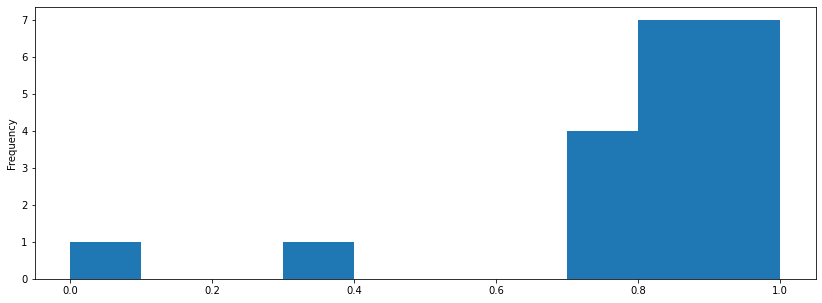

In [43]:
methods_indep_var[methods[0]].ratio_passed_builds.plot(kind="hist")

<Figure size 1008x360 with 0 Axes>

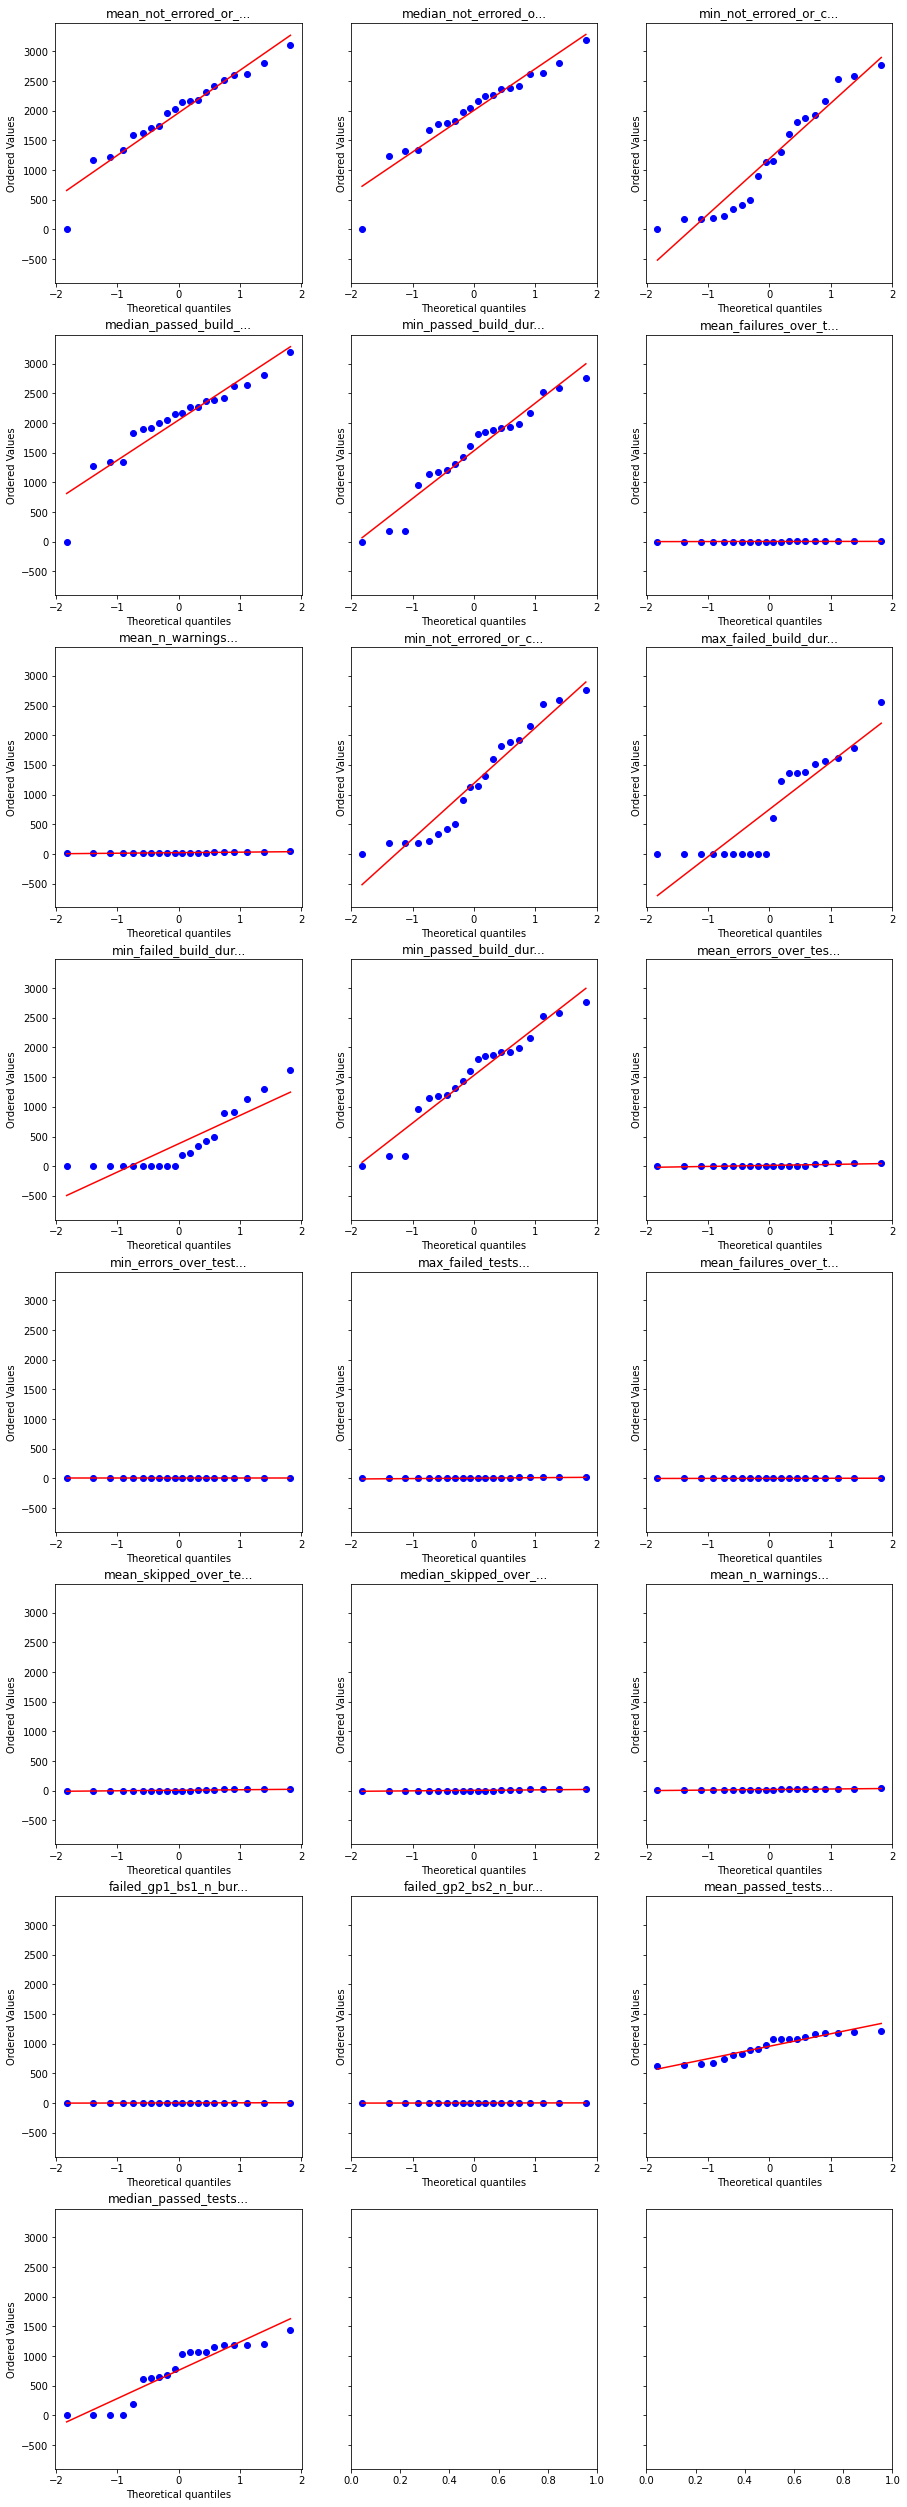

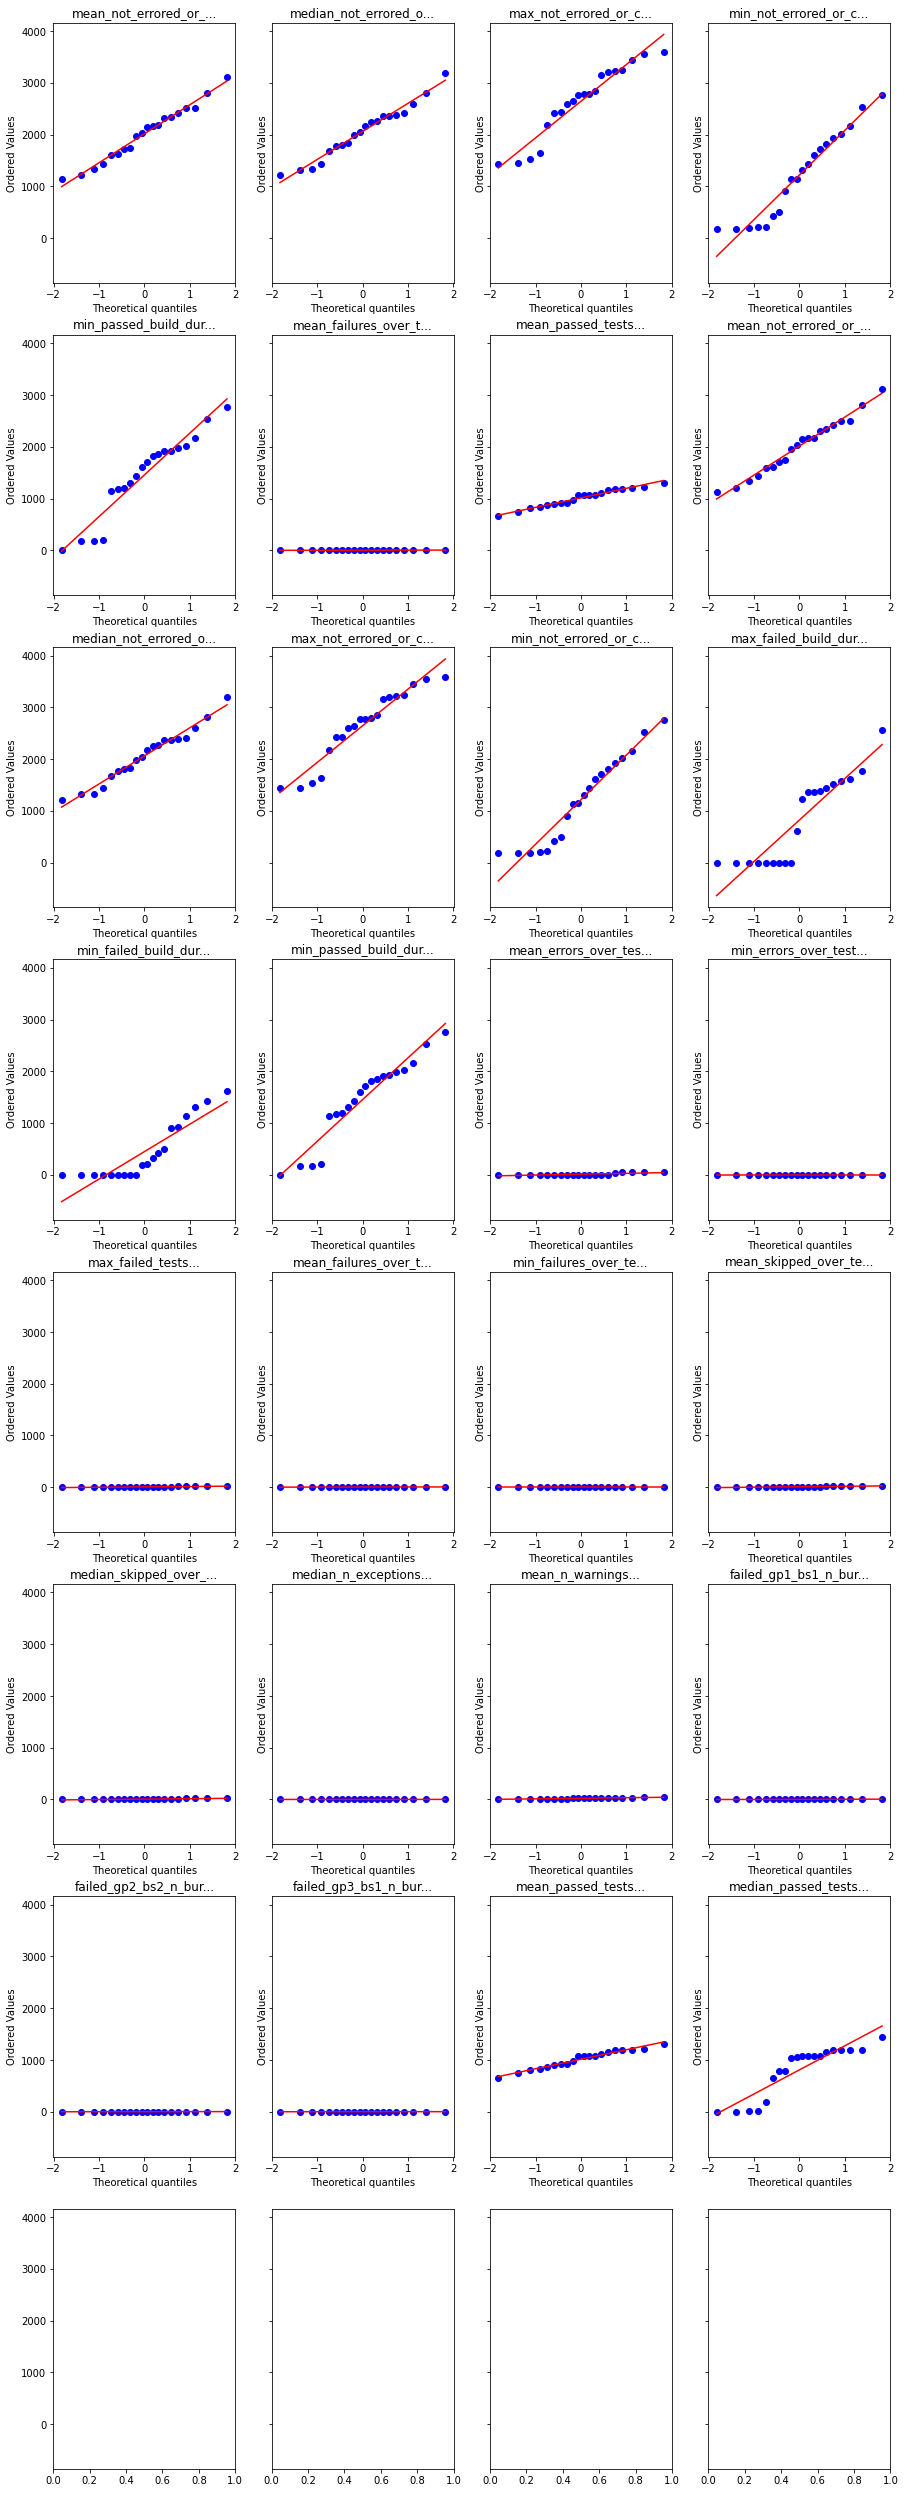

In [44]:
plt.figure()
normal_features = {}
for method in methods:
    df = methods_indep_var[method]
    normal_features[method] = method_normal_distributed_features[method]
    if(len(normal_features) < 1):
        continue
    fig, axes = plt.subplots(nrows=8, ncols=int(len(normal_features[method])/8)+1, sharey=True, figsize=(15.0, 45.0))
    axes = axes.flatten()
    for i, feat in enumerate(normal_features[method]):
        scipy.stats.probplot(df[feat], dist="norm", plot=axes[i])
        axes[i].set_title(feat[:20]+"...")
#plt.savefig(f"{figure_folder}/dataset_preprocessing/{mask_name}_qq-plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
#plt.show()

In [45]:
for method in methods:
    x = normal_features[method]
    print(method, len(x))

dataset1 22
dataset2 28


((array([-1.8241636 , -1.38768012, -1.11829229, -0.91222575, -0.73908135,
         -0.5857176 , -0.44506467, -0.31273668, -0.18568928, -0.06158146,
          0.06158146,  0.18568928,  0.31273668,  0.44506467,  0.5857176 ,
          0.73908135,  0.91222575,  1.11829229,  1.38768012,  1.8241636 ]),
  array([ 0.,  0.,  1.,  1.,  2.,  2.,  5.,  6.,  6.,  7.,  7.,  9.,  9.,
         10., 16., 18., 18., 18., 22., 23.])),
 (7.637746112583419, 8.999999999999998, 0.9580499420514086))

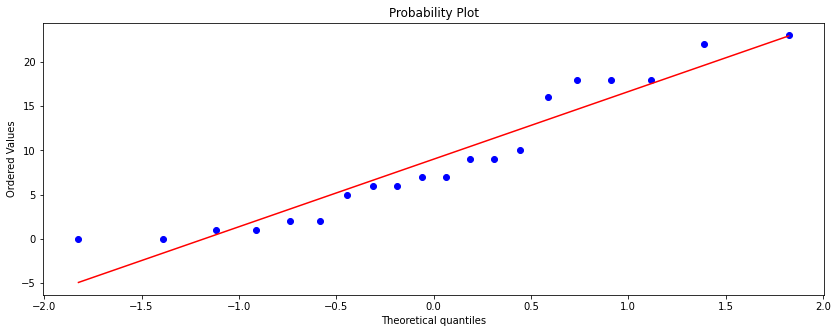

In [46]:
scipy.stats.probplot(methods_dep_var[method].post_release_bugs, dist="norm", plot=plt)

for method in methods:
    print(normaltest(methods_dep_var[method].post_release_bugs))

A visual test does not seem to confirm that these features are indeed normally distributed. We conclude that none of our features are normally distributed.

### Correlated features

<Figure size 1008x360 with 0 Axes>

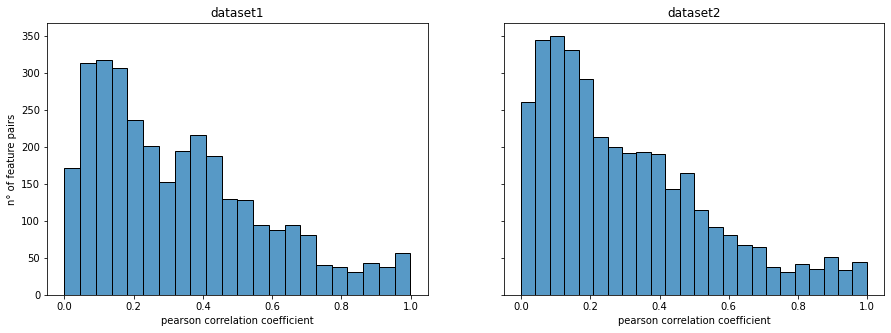

In [47]:
plt.figure()
methods_correlated_features = {}
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15.0, 5.0))
for i, method in enumerate(methods):
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_correlated_features[method] = sol[sol > 0.8]
    ax = sns.histplot(sol, ax=axes[i])
    ax.set_title(method)
    ax.set(xlabel="pearson correlation coefficient",ylabel="n° of feature pairs")
plt.savefig(f"{figure_folder}/dataset_preprocessing/{mask_name}_correlated_feature_dist.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [48]:
methods_correlated_features[methods[1]].head(10)

failed_gp2_bs3_burst_size_median  failed_gp3_bs3_burst_size_median    0.999
                                  failed_gp3_bs3_burst_size_max       0.999
failed_gp1_bs2_n_bursts_mean      failed_gp2_bs2_n_bursts_mean        0.999
failed_gp2_bs2_burst_size_mean    failed_gp3_bs2_burst_size_median    0.998
failed_gp2_bs1_burst_size_mean    failed_gp3_bs1_burst_size_mean      0.997
failed_gp3_bs3_burst_size_median  failed_gp3_bs3_burst_size_max       0.997
failed_gp3_bs2_burst_size_median  failed_gp3_bs2_burst_size_max       0.997
failed_gp1_bs1_burst_size_mean    failed_gp2_bs1_burst_size_mean      0.995
mean_passed_build_duration        median_passed_build_duration        0.994
max_n_warnings                    max_passed_tests                    0.994
dtype: float64

In [49]:
methods_correlated_features[methods[0]].head(10)

failed_gp2_bs3_burst_size_median             failed_gp3_bs3_burst_size_median                 0.999
                                             failed_gp3_bs3_burst_size_max                    0.999
failed_gp2_bs2_burst_size_mean               failed_gp3_bs2_burst_size_median                 0.998
mean_failed_tests                            mean_n_exceptions                                0.998
failed_gp2_bs1_burst_size_mean               failed_gp3_bs1_burst_size_mean                   0.997
failed_gp3_bs3_burst_size_median             failed_gp3_bs3_burst_size_max                    0.997
failed_gp3_bs2_burst_size_median             failed_gp3_bs2_burst_size_max                    0.997
median_failed_tests                          median_n_exceptions                              0.996
mean_not_errored_or_canceled_build_duration  median_not_errored_or_canceled_build_duration    0.995
mean_passed_build_duration                   median_passed_build_duration                     0.994


### Correlation with dependent variable
https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/

We proceed with analysing the correlation of our attributed with the three software quality metricsm
We calculate both types of correlation:
* Pearons (linear)
* Spearman (monotonic, is pearson applied to ranks)

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.

In [50]:
methods_pearson_corr_post_release_bugs = {}
methods_spearman_corr_post_release_bugs = {}
for method in methods:
    data = []
    corr_col = methods_dep_var[method].post_release_bugs
    x = methods_indep_var[method][normal_features[method]].apply(lambda x:\
                                scipy.stats.pearsonr(x, corr_col)).T
    x.columns = ["pearson_corr", "pval"]
    methods_pearson_corr_post_release_bugs[method] = x

    x = methods_indep_var[method].drop(normal_features[method], axis=1).apply(lambda x:\
                                scipy.stats.spearmanr(x, corr_col)).T
    x.columns = ["spearman_corr", "pval"]
    methods_spearman_corr_post_release_bugs[method] = x

**Feature category correlation per each dataset**

In [51]:
feature_categories = ["ratio_(.*)_builds",
                     "(.*)_(.*)_build_duration",
                     "(.*)_n_builds_per_pull_request",
                     "(.*)_errors_over_tests_total",
                     "(.*)_failed_tests",
                     "(.*)_failures_over_tests_total",
                     "(.*)_skipped_over_tests_total",
                     "(.*)_n_exceptions",
                     "(.*)_n_warnings",
                     "(.*)_n_error_classes",
                     #"(.*)_burst_size",
                     "(.*)burst"]

In [52]:
linearly_corr_features = {}
for method in methods:
    x = methods_pearson_corr_post_release_bugs[method]
    linearly_corr_features[method] = x[x.pval < 0.05].index
    x["abs"] = x.pearson_corr.abs()
    print(x[x.pval < 0.05].sort_values(by="abs",ascending=False)[["pearson_corr"]].round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  pearson\_corr \\
\midrule
median\_not\_errored\_or\_canceled\_build\_duration &         -0.81 \\
mean\_not\_errored\_or\_canceled\_build\_duration   &         -0.79 \\
median\_passed\_build\_duration                  &         -0.78 \\
mean\_passed\_tests                             &         -0.76 \\
mean\_failures\_over\_tests\_total                &         -0.62 \\
mean\_failures\_over\_tests\_total                &         -0.62 \\
min\_not\_errored\_or\_canceled\_build\_duration    &         -0.57 \\
min\_not\_errored\_or\_canceled\_build\_duration    &         -0.57 \\
mean\_skipped\_over\_tests\_total                 &         -0.54 \\
max\_failed\_tests                              &          0.45 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  pearson\_corr \\
\midrule
median\_not\_errored\_or\_canceled\_build\_duration &         -0.81 \\
median\_not\_errored\_or\_canceled\_build\_duration &         -0.81 \\
mean\_not\_error

In [53]:
for method in methods:
    x = methods_spearman_corr_post_release_bugs[method]
    x["abs"] = x.spearman_corr.abs()
    print(x[x.pval < 0.05].sort_values(by="abs",ascending=False)[["spearman_corr"]].round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
max\_passed\_build\_duration        &          -0.68 \\
mean\_passed\_build\_duration       &          -0.66 \\
max\_skipped\_over\_tests\_total     &          -0.64 \\
max\_passed\_tests                 &          -0.62 \\
min\_skipped\_over\_tests\_total     &          -0.61 \\
failed\_gp3\_bs1\_n\_bursts\_min      &           0.59 \\
median\_failures\_over\_tests\_total &          -0.47 \\
ratio\_failed\_builds              &           0.45 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
median\_passed\_build\_duration     &          -0.72 \\
mean\_passed\_build\_duration       &          -0.69 \\
max\_passed\_build\_duration        &          -0.68 \\
ratio\_failed\_builds              &           0.65 \\
max\_skipped\_over\_tests\_total     &          -0.64 \\
min\_skipped\_over\_tests\_total     &          -0.60 \\
median\_failures\_over\_tests\_total &          -0.57 \\
min\

In [54]:
import re
for cat in feature_categories:
    print("-"*10)
    print(cat)
    for method in methods:
        x = methods_spearman_corr_post_release_bugs[method]
        x = x[x.pval < 0.05].round(2)
        print(method, "\n", x[[True if re.search(cat, s) else False for s in x.index]]\
              .spearman_corr.sort_values(ascending=False).to_latex())

----------
ratio_(.*)_builds
dataset1 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
ratio\_failed\_builds &           0.45 \\
\bottomrule
\end{tabular}

dataset2 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
ratio\_failed\_builds &           0.65 \\
\bottomrule
\end{tabular}

----------
(.*)_(.*)_build_duration
dataset1 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
mean\_passed\_build\_duration &          -0.66 \\
max\_passed\_build\_duration  &          -0.68 \\
\bottomrule
\end{tabular}

dataset2 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
mean\_failed\_build\_duration   &           0.45 \\
max\_passed\_build\_duration    &          -0.68 \\
mean\_passed\_build\_duration   &          -0.69 \\
median\_passed\_build\_duration &          -0.72 \\
\bottomrule
\end{tabular}

----------
(.*)_n_builds_per_pull_request
dataset1 
 \begin{tabular}{lr}
\toprule
Empty DataFrame
Columns: Index(['spearman\_corr'], dtype='obj

In [55]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr

median_passed_build_duration       -0.721515
mean_passed_build_duration         -0.692835
max_passed_build_duration          -0.678495
ratio_failed_builds                 0.654374
max_skipped_over_tests_total       -0.636126
min_skipped_over_tests_total       -0.601791
median_failures_over_tests_total   -0.567551
min_n_warnings                     -0.511722
median_errors_over_tests_total     -0.489999
max_n_exceptions                    0.479900
mean_failed_build_duration          0.448646
Name: spearman_corr, dtype: float64

In [56]:
spearman_corr[[col for col in spearman_corr.index if re.search("(.*)_(.*)_build_duration", col)]]

median_passed_build_duration   -0.721515
mean_passed_build_duration     -0.692835
max_passed_build_duration      -0.678495
mean_failed_build_duration      0.448646
Name: spearman_corr, dtype: float64

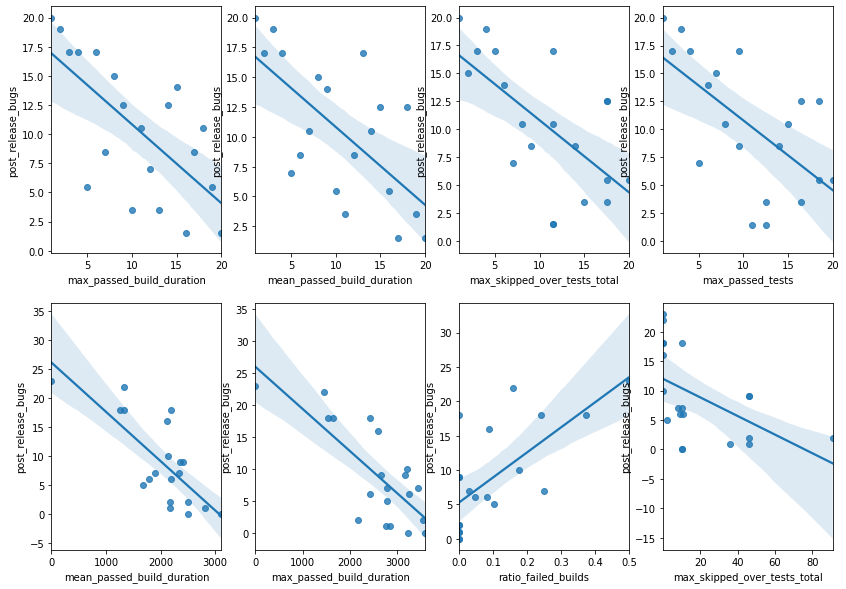

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14.0, 10.0))
axes = axes.flatten()

corr = methods_spearman_corr_post_release_bugs[methods[0]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for i in range(4):
    feature = spearman_corr.index[i]
    sns.regplot(x=methods_indep_var[methods[0]][feature].rank(),
                   y=methods_dep_var[methods[0]].post_release_bugs.rank(), ax=axes[i])
    
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for j in range(i+1, 8):
    feature = spearman_corr.index[j-i]
    sns.regplot(x=methods_indep_var[methods[1]][feature],
                   y=methods_dep_var[methods[1]].post_release_bugs, ax=axes[j])

df = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

(0.4504268030899486, 0.04626350948986403)


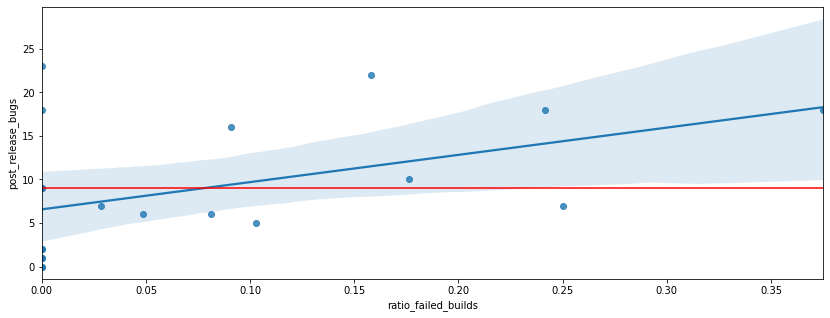

In [58]:
df_ind = methods_indep_var[methods[0]]
df_dep = methods_dep_var[methods[0]]
x = df_ind.ratio_failed_builds
y = df_dep.post_release_bugs
print(scipy.stats.pearsonr(x,y))
ax = sns.regplot(x=x, y=y)
ax.axhline(y=df_dep.post_release_bugs.mean(), color="r")

In [59]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr[spearman_corr.abs() > 0.35].index

Index(['median_passed_build_duration', 'mean_passed_build_duration',
       'max_passed_build_duration', 'ratio_failed_builds',
       'max_skipped_over_tests_total', 'min_skipped_over_tests_total',
       'median_failures_over_tests_total', 'min_n_warnings',
       'median_errors_over_tests_total', 'max_n_exceptions',
       'mean_failed_build_duration'],
      dtype='object')

cols = ['max_failed_tests', 'max_n_builds_per_pull_request',
       'mean_failed_tests', 'failed_gp3_bs1_n_bursts_max',
       'failed_gp3_bs3_burst_size_max', 'max_failed_build_duration',
       'max_n_error_classes', 'median_skipped_over_tests_total',
       'failed_gp1_bs1_burst_size_mean', 'max_n_exceptions',
       'ratio_passed_builds','mean_n_builds_per_pull_request',
        'min_skipped_over_tests_total', 'max_failures_over_tests_total']
df = methods_indep_var[methods[1]][cols].corr(method="spearman")
cols = []
matrix = np.triu(df) 
ax = sns.heatmap(df, cmap= 'coolwarm', mask=matrix, annot=True) 
#ax.set_title(method) 
plt.show()

<AxesSubplot:>

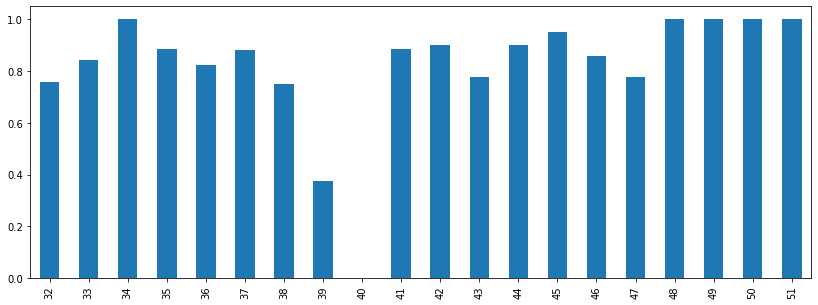

In [60]:
methods_indep_var[methods[1]].ratio_passed_builds.plot(kind="bar")

In [61]:
methods_dep_var[methods[1]].post_release_bugs.describe()

count    20.000000
mean      9.000000
std       7.567242
min       0.000000
25%       2.000000
50%       7.000000
75%      16.500000
max      23.000000
Name: post_release_bugs, dtype: float64

<AxesSubplot:>

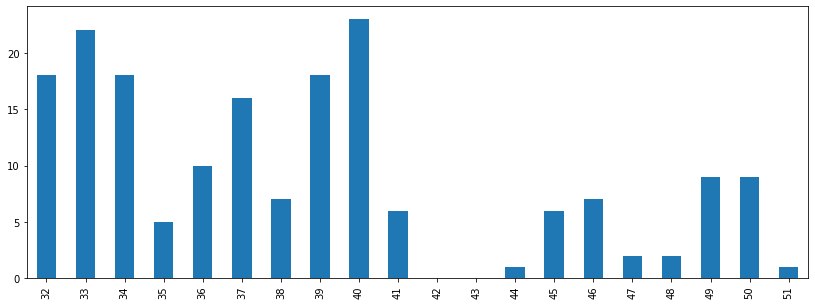

In [62]:
methods_dep_var[methods[1]].post_release_bugs.plot(kind="bar")

<AxesSubplot:>

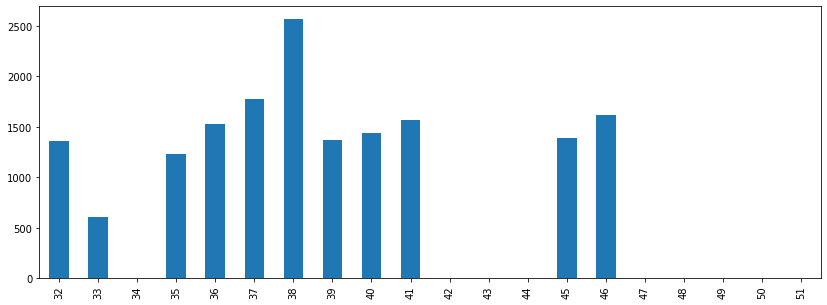

In [63]:
methods_indep_var[methods[1]].max_failed_build_duration.plot(kind="bar")

In [64]:
methods_indep_var[methods[1]].max_failed_build_duration.corr(\
                        methods_indep_var[methods[1]].min_not_errored_or_canceled_build_duration, method="spearman")

-0.7851286633145668

**Remove highly correlated features?**

In [65]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    print(method, len(methods_correlated_features[method]))
    corr_matrix = methods_indep_var[method].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    methods_corr_cols_to_remove[method] = [column for column in upper.columns if any(upper[column] > 0.95)]

dataset1 179
dataset2 192


In [66]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(20, 50)
(20, 59)


for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

### Play with feature selection

In [67]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, RFECV
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, make_scorer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [68]:
regression_mask = mask_to_use
cross_validation_strategy = KFold(3, shuffle=True, random_state=1)

In [69]:
method_x_train = {}
method_y_train = {}
method_train_columns = {}
for method in methods:
    X_train = methods_indep_var[method][regression_mask]
    y_train = methods_dep_var[method].post_release_bugs[regression_mask]
    train_columns = X_train.columns
    X_train[X_train.columns] = StandardScaler().fit_transform(X_train)
    method_x_train[method] = X_train
    method_y_train[method] = y_train
    method_train_columns[method] = train_columns

<ipython-input-69-4f638e0bc459>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = methods_indep_var[method][regression_mask]
<ipython-input-69-4f638e0bc459>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = methods_indep_var[method][regression_mask]


In [70]:
def two_layer_cross_validate(model, params_grid, x, y, seed, n_splits, scoring=None):
    inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=params_grid, cv=inner_cv)
    return cross_val_score(clf, x, y, cv=outer_cv, scoring=scoring)

In [71]:
def two_layer_cross_validate_cv(model, params_grid, x, y, seed, cv, scoring=None):
    inner_cv = cv
    outer_cv = cv

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=params_grid, cv=inner_cv)
    return cross_val_score(clf, x, y, cv=outer_cv, scoring=scoring)

In [72]:
def outer_layer_cross_validate(model, x, y, seed, n_splits, scoring=None):
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return cross_val_score(model, x, y, cv=outer_cv, scoring=scoring)

In [73]:
def forward_feature_selection(model, X, y, cv=5, scoring="r2"):
    best_performance = np.array([-100])
    added_columns = list()
    feature_performance = {}
    feature_performance["All features"] = perf = cross_val_score(model, X,\
                                   y, cv=cv, scoring=scoring)
    while(True):
        #print("Best perf", best_performance)
        current_perf = best_performance
        curr_col = None
        for col in X.columns:
            if col in added_columns:
                continue
            perf = cross_val_score(model, X[set(added_columns).union(set([col]))],\
                                   y, cv=cv, scoring=scoring)
            #print(added_columns.union(set([col])), perf.mean())
            if current_perf.min() < perf.min():
                current_perf = perf
                curr_col = col
        if current_perf.mean() <= best_performance:
            break
        else:
            best_performance = current_perf.min()
            added_columns.append(curr_col)
            feature_performance[curr_col] = current_perf
            #print(added_columns)
    return added_columns, best_performance, feature_performance

**Regression**

Removing outlier

<AxesSubplot:>

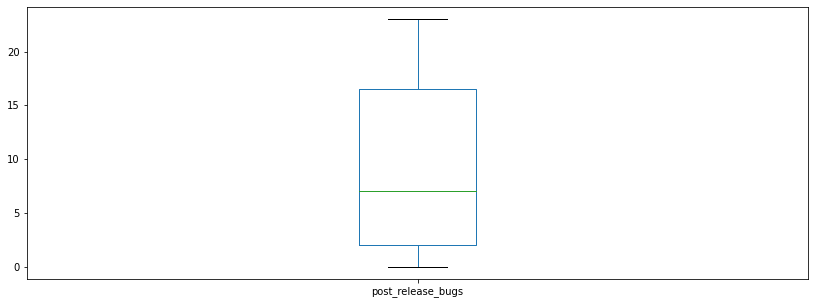

In [100]:
method_y_train[methods[0]].plot(kind="box")

for method in methods:
    y_train = methods_dep_var[method].post_release_bugs[regression_mask]
    method_y_train[method] = y_train[y_train < 50]
    method_x_train[method] = method_x_train[method][y_train < 50]

In [102]:
method_dt_regr_features = {}
method_dt_regr_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(DecisionTreeRegressor(), method_x_train[method],\
                                           method_y_train[method], cv=cross_validation_strategy, scoring="r2")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_dt_regr_features[method] = features
    method_dt_regr_feature_performance[method] = feature_performance

--------------------
dataset1 ['median_skipped_tests', 'mean_failed_tests', 'min_skipped_over_tests_total', 'min_failed_build_duration', 'min_passed_build_duration', 'max_failed_build_duration'] 0.42307692307692313
--------------------
--------------------
dataset2 ['mean_passed_build_duration', 'min_failed_build_duration'] 0.48105436573311366
--------------------


In [103]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 4)]
min_samples_leaf = [1,2,3,4]
max_depth = [1,2,3,4]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeRegressor()
method_dt_r2 = {}
method_dt_neg_mean_error = {}
for method in methods:
    x = method_x_train[method][method_dt_regr_features[method]]
    method_dt_r2[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 3, "r2")
    method_dt_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 3, "neg_mean_absolute_error")

In [105]:
for method in methods:
    print("R2","-"*40)
    print(method, method_dt_r2[method])
    print("Nmae","-"*40)
    print(method, method_dt_neg_mean_error[method])

R2 ----------------------------------------
dataset1 [ 0.51726695 -0.02413995 -1.39107722]
Nmae ----------------------------------------
dataset1 [-5.         -5.         -7.96666667]
R2 ----------------------------------------
dataset2 [0.8167059  0.63602478 0.65189988]
Nmae ----------------------------------------
dataset2 [-1.35714286 -3.71428571 -2.48484848]


In [106]:
method_knn_regr_features = {}
method_knn_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsRegressor(), method_x_train[method],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_regr_features[method] = features
    method_knn_feature_performance = feature_performance

--------------------
dataset1 ['mean_not_errored_or_canceled_build_duration', 'mean_failures_over_tests_total', 'failed_gp1_bs1_n_bursts_min', 'min_errors_over_tests_total', 'min_not_errored_or_canceled_build_duration'] 0.3107692307692308
--------------------
--------------------
dataset2 ['max_not_errored_or_canceled_build_duration', 'median_failures_over_tests_total', 'min_failures_over_tests_total', 'min_errors_over_tests_total', 'failed_gp1_bs1_n_bursts_median'] 0.4924711696869851
--------------------


<Figure size 1008x360 with 0 Axes>

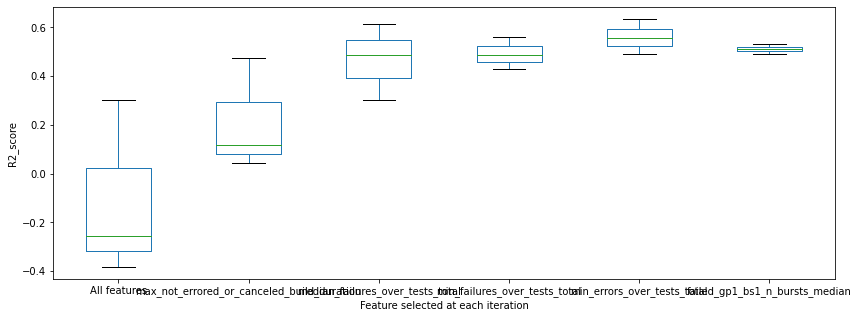

In [107]:
plt.figure()
ax = pd.DataFrame(method_knn_feature_performance).plot(kind="box")
ax.set(ylabel="R2_score", xlabel="Feature selected at each iteration")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_feature_selection_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [108]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 4, num = 4)],
              'p': [1,2,3]}
model = KNeighborsRegressor()
method_knregressor_r2 = {}
method_knregressor_neg_mean_error = {}
for method in methods:
    x = method_x_train[method][method_knn_regr_features[method]]
    method_knregressor_r2[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 3, "r2")
    method_knregressor_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 3, "neg_mean_absolute_error")

In [109]:
for method in methods:
    print("R2", method, method_knregressor_r2[method], method, method_knregressor_r2[method].mean())
    print("Mae", method, method_knregressor_neg_mean_error[method], method_knregressor_neg_mean_error[method].mean())

R2 dataset1 [ 0.22090395  0.43696247 -0.58007626] dataset1 0.025930054124919038
Mae dataset1 [-6.57142857 -4.64285714 -5.08333333] -5.432539682539683
R2 dataset2 [0.87443503 0.7236122  0.18207817] dataset2 0.5933751316543104
Mae dataset2 [-2.85714286 -2.85714286 -4.5       ] -3.404761904761905


In [110]:
method_lin_regr_features = {}
method_lin_regr_feature_performance = {}
for i, method in enumerate(methods):
    columns = method_x_train[method].columns.intersection(normal_features[method])
    features, score, feature_performance = forward_feature_selection(LinearRegression(), method_x_train[method][columns],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_lin_regr_features[method] = features
    if i == 0:
        method_lin_regr_feature_performance = feature_performance

--------------------
dataset1 ['mean_not_errored_or_canceled_build_duration', 'failed_gp1_bs1_n_bursts_max', 'mean_failures_over_tests_total', 'mean_passed_tests', 'max_failed_build_duration', 'mean_skipped_over_tests_total', 'min_failed_build_duration'] 0.5468488805418825
--------------------
--------------------
dataset2 ['max_not_errored_or_canceled_build_duration', 'min_failed_build_duration', 'min_not_errored_or_canceled_build_duration', 'median_passed_tests'] 0.4266039013770573
--------------------


<Figure size 1008x360 with 0 Axes>

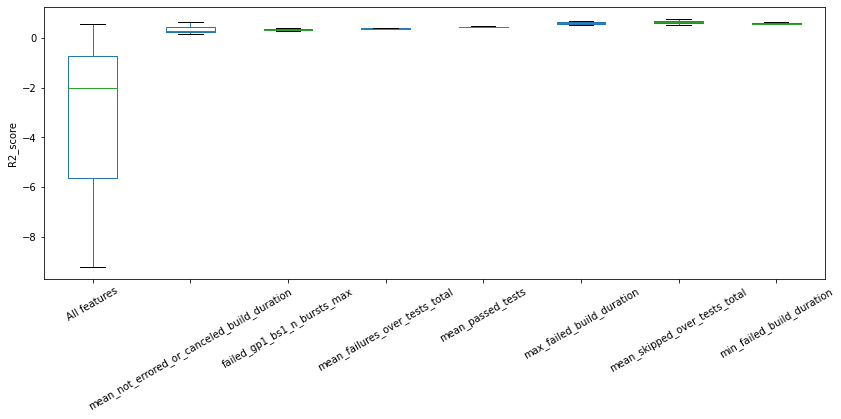

In [111]:
plt.figure()
ax = pd.DataFrame(method_lin_regr_feature_performance).plot(kind="box", showfliers=False)
ax.set(ylabel="R2_score")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/linreg_feature_selection_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [112]:
method_linregression_r2 = {}
method_linregression_nmae = {}
for method in methods:
    features = method_lin_regr_features[method]
    method_linregression_r2[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 3, scoring="r2")
    method_linregression_nmae[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 3, scoring="neg_mean_absolute_error")

In [113]:
for method in methods:
    print("R2", method, method_linregression_r2[method], method_linregression_r2[method].mean())
    print("Nmae","-"*40)
    print(method, method_linregression_nmae[method])

R2 dataset1 [0.77210423 0.63485915 0.60399331] 0.6703188985209433
Nmae ----------------------------------------
dataset1 [-3.21063632 -3.82649336 -2.82115197]
R2 dataset2 [0.62598353 0.60484704 0.42317365] 0.5513347415987007
Nmae ----------------------------------------
dataset2 [-4.5011599  -3.91270054 -3.05519096]


is_small = y_train < y_train.quantile(.25)
is_large = y_train > y_train.quantile(.75)
is_medium = ~(is_small | is_large)

y_quantiles = y_train.mask(is_small, 'small').mask(is_large, 'large').mask(is_medium, 'medium')

<Figure size 1008x360 with 0 Axes>

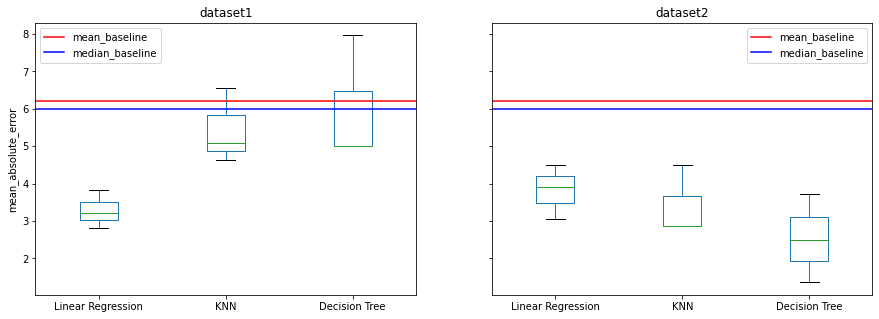

In [114]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"Linear Regression":method_linregression_nmae,
          "KNN": method_knregressor_neg_mean_error,
          "Decision Tree": method_dt_neg_mean_error
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = -score[method]
    ax = pd.DataFrame(data).plot(kind="box", showfliers=False, ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    ax.axhline(y=mean_absolute_error(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=mean_absolute_error(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="median_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="mean_absolute_error")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_neg_mean_absolute_error.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

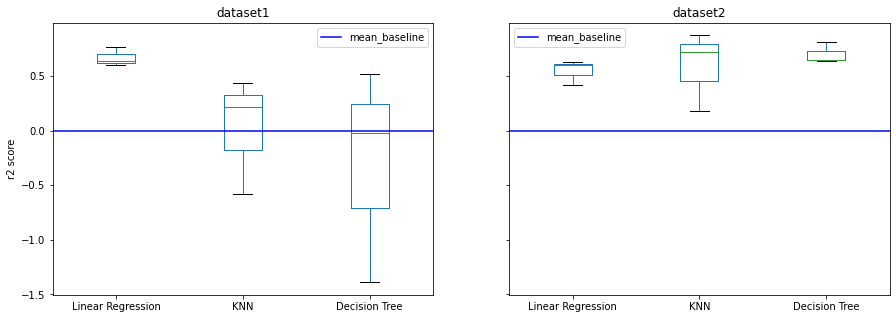

In [115]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"Linear Regression":method_linregression_r2,
          "KNN": method_knregressor_r2, 
          "Decision Tree": method_dt_r2
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    #ax.axhline(y=r2_score(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=r2_score(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="mean_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="r2 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Linear Regression analysis**

In [89]:
m = methods[0]
method_name = "dataset1"

In [90]:
x = method_x_train[m][method_lin_regr_features[m]]
y = methods_dep_var[m].post_release_bugs
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, random_state=42)
model = LinearRegression().fit(x,y)

In [91]:
tmp = x.copy()
tmp["predicted"] = model.predict(x)
tmp["true"] = y
tmp

,mean_not_errored_or_canceled_build_duration,failed_gp1_bs1_n_bursts_max,mean_failures_over_tests_total,mean_passed_tests,max_failed_build_duration,mean_skipped_over_tests_total,min_failed_build_duration,predicted,true
32,-1.167699,0.711388,-0.559466,-1.575248,0.746080,-0.832427,-0.079544,18.927936,18.0
33,-1.090799,-0.426833,-0.525345,-1.467369,-0.180720,-0.832428,0.241020,21.134134,22.0
34,-0.901786,-0.995943,-0.121988,-1.369959,-0.915810,-0.832430,-0.750537,18.995819,18.0
35,-0.530765,2.418719,-0.095000,-1.073327,0.584897,-0.814095,-0.376214,6.153403,5.0
36,0.001863,0.142278,-1.469692,-0.294761,0.943894,-0.832423,1.041433,13.565582,10.0
37,0.099585,0.711388,-1.324922,-0.724315,1.256491,-0.832439,0.081734,13.368533,16.0
38,-0.501663,1.849609,1.409301,-0.603695,2.217480,-0.663098,-0.314491,7.315858,7.0
39,-0.365938,0.142278,-0.896400,0.068720,0.754627,-0.634190,1.507346,11.492273,18.0
40,-2.857954,-0.426833,-1.548871,-1.621666,-0.915810,-0.832468,-0.750537,22.553001,23.0
41,-0.320560,1.849609,0.262865,-0.212571,1.002506,-0.408870,1.083246,5.673426,6.0


In [92]:
residuals = y - model.predict(x)

<AxesSubplot:ylabel='Frequency'>

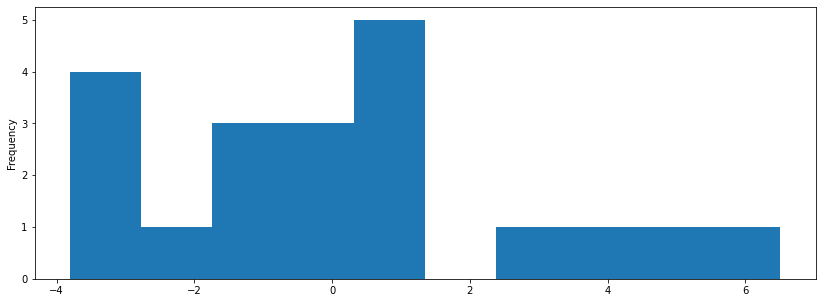

In [93]:
residuals.plot(kind="hist")

In [119]:
normaltest(residuals)

NormaltestResult(statistic=1.8449220415129677, pvalue=0.3975394833029685)

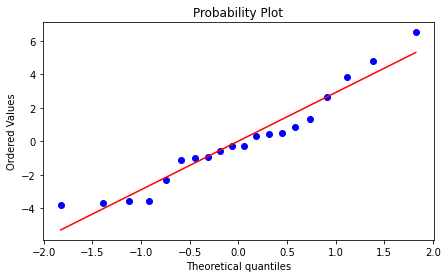

In [94]:
plt.figure(figsize=(7,4))
ax = stats.probplot(residuals, dist="norm", plot=plt)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/qqplot_residuals{method_name}.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

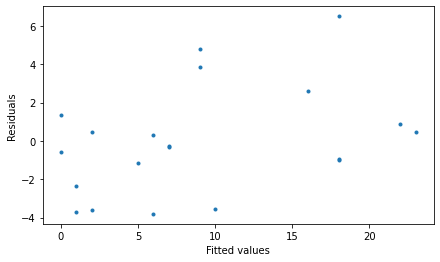

In [95]:
plt.figure(figsize=(7,4))
plt.plot(y,residuals,'.')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/fitted_vs_predicted_residuals{method_name}.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

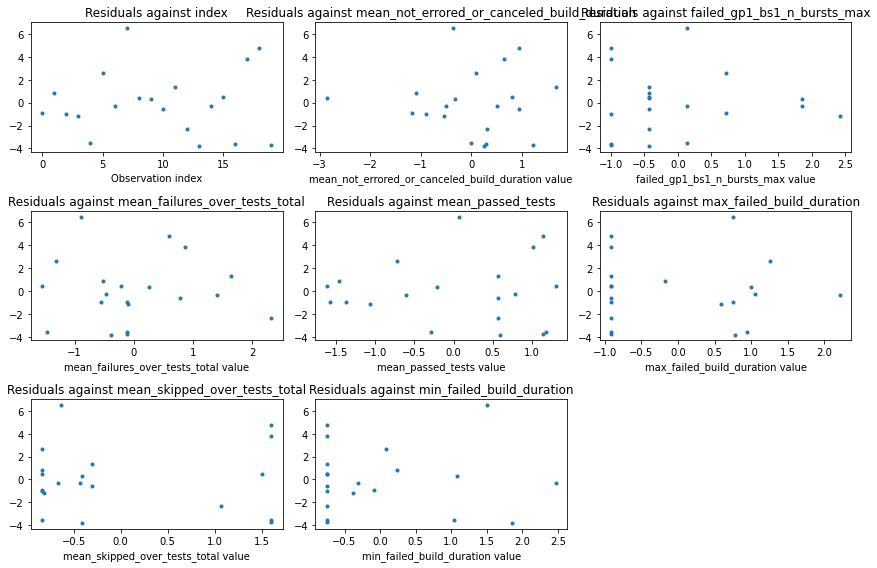

In [96]:
fig = plt.figure(figsize=(12,8))
i = 0

fig.add_subplot(3, 3, i+1)
i+=1
plt.plot(residuals.values,'.')
plt.title("Residuals against index")
plt.xlabel("Residual value")
plt.xlabel("Observation index")
plt.subplots_adjust(wspace=0.4)

for col in method_lin_regr_features[m]:
    fig.add_subplot(3, 3, i+1)
    i+=1
    plt.plot(x[col],residuals,'.')
    plt.title("Residuals against " +str(col))
    plt.xlabel("Residual value")
    plt.xlabel(str(col)+" value")
    plt.subplots_adjust(wspace=0.4)
    plt.tight_layout()
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/indep_residuals{method_name}.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

In [97]:
model.intercept_

9.0

In [98]:
pd.Series(model.coef_, x.columns)

mean_not_errored_or_canceled_build_duration   -1.215143
failed_gp1_bs1_n_bursts_max                   -4.114793
mean_failures_over_tests_total                -1.169567
mean_passed_tests                             -7.362530
max_failed_build_duration                      2.180844
mean_skipped_over_tests_total                  2.794245
min_failed_build_duration                      1.470770
dtype: float64

### Binary

In [74]:
method_y_bin_train = {}
for method in methods:
    method_y_bin_train[method] = method_y_train[method] > method_y_train[method].median()

In [75]:
method_y_bin_train[method].sum()

9

In [76]:
method_y_train[method].median()

7.0

In [83]:
method_dt_bin_features = {}
method_dt_bin_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(DecisionTreeClassifier(), method_x_train[method],\
                                           method_y_bin_train[method], cv=cross_validation_strategy, scoring="f1")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_dt_bin_features[method] = features
    method_dt_bin_feature_performance[method] = feature_performance

--------------------
dataset1 ['max_n_exceptions'] 0.7499999999999999
--------------------
--------------------
dataset2 ['mean_not_errored_or_canceled_build_duration'] 0.5714285714285715
--------------------


In [93]:
min_samples_leaf = [1,2,3,4]
max_depth = [1,2,3,4,5,6]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeClassifier()
method_dtclassifier_binary_f1 = {}
method_dtclassifier_binary_accuracy = {}
method_dtclassifier_binary_auc = {}
for method in methods:
    x = method_x_train[method][method_dt_bin_features[method]]
    print(x.columns)
    method_dtclassifier_binary_f1[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 3, "f1")
    method_dtclassifier_binary_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 3, "accuracy")

Index(['max_n_exceptions'], dtype='object')
Index(['mean_not_errored_or_canceled_build_duration'], dtype='object')


In [94]:
for method in methods:
    print(method, "Accuracy", method_dtclassifier_binary_accuracy[method], method_dtclassifier_binary_accuracy[method].mean())
    print(method, "F1", method_dtclassifier_binary_f1[method], method_dtclassifier_binary_f1[method].mean())
    #print(method, method_dtclassifier_binary_auc[method])

dataset1 Accuracy [0.57142857 0.85714286 0.83333333] 0.753968253968254
dataset1 F1 [0.4        0.85714286 0.66666667] 0.6412698412698412
dataset2 Accuracy [0.71428571 0.57142857 0.5       ] 0.5952380952380952
dataset2 F1 [0.66666667 0.4        0.4       ] 0.48888888888888893


In [95]:
method_knn_bin_features = {}
method_knn_bin_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsClassifier(), method_x_train[method],\
                                           method_y_bin_train[method], cv=cross_validation_strategy, scoring="f1")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_bin_features[method] = features
    method_knn_bin_feature_performance[method] = feature_performance

--------------------
dataset1 ['mean_skipped_over_tests_total'] 0.6666666666666666
--------------------
--------------------
dataset2 ['mean_skipped_over_tests_total'] 0.6666666666666666
--------------------


In [96]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 4, num = 4)],
              'p': [1,2,3]}
model = KNeighborsClassifier()
method_knn_f1 = {}
method_knn_accuracy = {}
method_knn_auc = {}
for method in methods:
    x = method_x_train[method][method_knn_bin_features[method]]
    method_knn_f1[method] = \
            two_layer_cross_validate(model, params_grid,  x, method_y_bin_train[method], 4, 3, "f1")
    method_knn_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 4, 3, "accuracy")
    method_knn_auc[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 4, 3, "roc_auc")


In [97]:
for method in methods:
    print(method, "Accuracy", method_knn_accuracy[method], method_knn_accuracy[method].mean())
    print(method, "F1", method_knn_f1[method], method_knn_f1[method].mean())
    print(method, method_knn_auc[method])

dataset1 Accuracy [0.57142857 0.85714286 0.66666667] 0.6984126984126983
dataset1 F1 [0.57142857 0.66666667 0.75      ] 0.6626984126984127
dataset1 [0.625 0.9   0.625]
dataset2 Accuracy [0.57142857 0.85714286 0.66666667] 0.6984126984126983
dataset2 F1 [0.57142857 0.66666667 0.75      ] 0.6626984126984127
dataset2 [0.625 0.9   0.625]


<Figure size 1008x360 with 0 Axes>

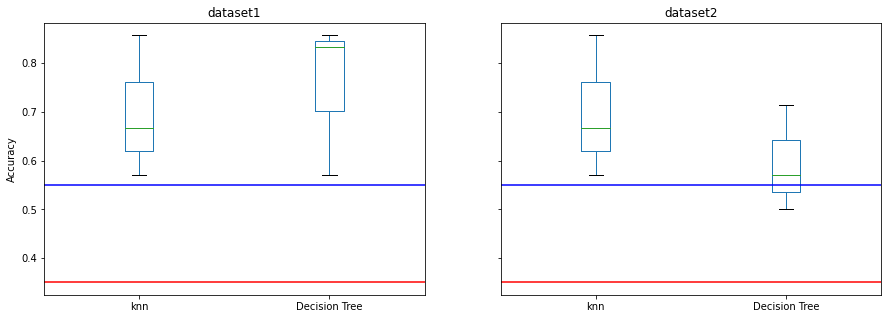

In [98]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_accuracy, 
          "Decision Tree": method_dtclassifier_binary_accuracy}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    #ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="Accuracy")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_accuracy.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

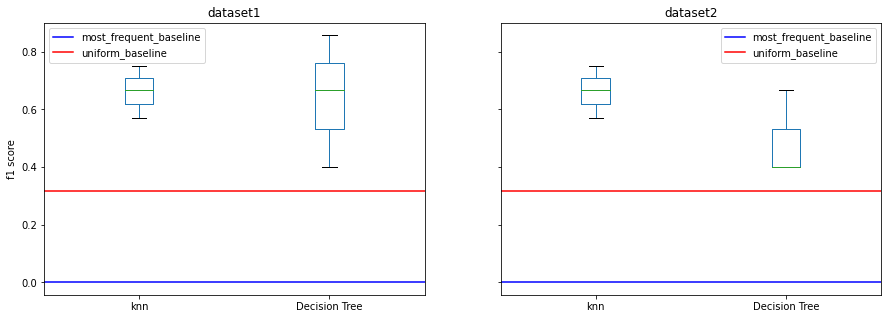

In [99]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_f1, 
          "Decision Tree": method_dtclassifier_binary_f1}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=f1_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=f1_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="f1 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_f1.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<ipython-input-111-13c40d829efc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["classes"] = method_y_bin_train[method].map({True:"large", False:"small"})


<Figure size 1008x360 with 0 Axes>

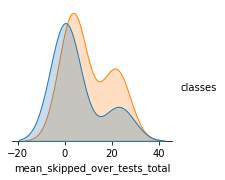

In [111]:
for i, method in enumerate([methods[0]]):
    plt.figure()
    df = methods_indep_var[method][method_knn_bin_features[method]]
    #if i == 0:
        #df = df[(df.max_all_build_duration < 0.00) & (df.max_n_builds_per_pull_request < 5)]
    #if i == 1:
        #df = df[(df.mean_failed_tests < 0.05) & (df.max_n_builds_per_pull_request < 1)]
    df["classes"] = method_y_bin_train[method].map({True:"large", False:"small"})
    """sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                    hue="quantiles", palette="deep")"""
    sns.pairplot(df, hue="classes",corner=True)
    plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_{method}_bin_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

In [ ]:
from sklearn.tree import plot_tree
dt = DecisionTreeClassifier()
dt.fit(methods_indep_var[methods[1]], method_y_bin_train[methods[1]])
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(dt, feature_names=method_x_train[methods[1]].columns, filled=True, class_names=["small", "large"], fontsize=10)
plt.show()

In [ ]:
methods_dep_var[method]

In [ ]:
df

<ipython-input-110-e0872616672a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["classes"] = method_y_bin_train[m].map({False:"small", True:"large"})
<ipython-input-110-e0872616672a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[""] = ""
<ipython-input-110-e0872616672a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

<Figure size 1008x360 with 0 Axes>

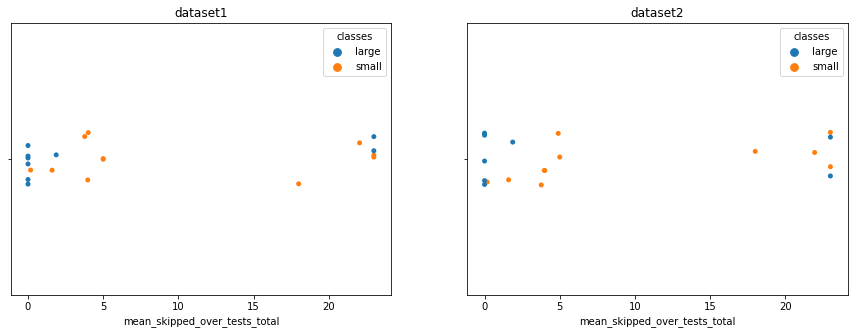

In [110]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15.0, 5.0))
for i, method in enumerate(methods):
    df = methods_indep_var[method][method_knn_bin_features[method]]
    y = methods_dep_var[method].post_release_bugs
    df["classes"] = method_y_bin_train[m].map({False:"small", True:"large"})
    df[""] = ""
    ax = sns.stripplot(x="mean_skipped_over_tests_total",\
                         y="",hue="classes", data=df, ax=axes[i])
    ax.set_title(method)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_binary_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

In [ ]:
plt.figure()
m = methods[1]
df = method_x_train[m][method_knn_quantiles_features[m]]
df["classes"] = method_y_bin_train[m].map({False:"small", True:"large"})
"""sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                hue="quantiles", palette="deep")"""
sns.pairplot(df, hue="classes",corner=True)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_method1_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**----------------------------------------**

### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X = methods_indep_var[methods[1]][mask]
X = StandardScaler().fit_transform(X)
y = methods_dep_var[methods[1]][mask].java_build_tool.reset_index(drop=True)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [ ]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [ ]:
pca.explained_variance_ratio_[:1].sum()

In [ ]:
data = []
for i in range(1, len(pca.explained_variance_ratio_)):
    data.append((i, pca.explained_variance_ratio_[:i].sum()))
pd.DataFrame(data)[1].plot(kind="bar")

In [ ]:
X_pca = pca.transform(X)

In [ ]:
y_bugs = methods_dep_var[methods[1]].post_release_bugs

In [ ]:
#plt.scatter(X_pca, y)
n_components = 4
fig, axes = plt.subplots(nrows=n_components, ncols=n_components, sharey=True, figsize=(10.0, 14.0))
for i in range(0,n_components):
    for j in range(0,n_components):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ["pink",'orange','red','brown','black']
        ranges = [(0,y_bugs.quantile(0.25)),(y_bugs.quantile(0.25),y_bugs.quantile(0.5))\
                  ,(y_bugs.quantile(0.5),y_bugs.quantile(0.75)), (y_bugs.quantile(0.75),y_bugs.quantile(1))]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y_bugs>=rang[0]) & (y_bugs<rang[1])
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)

In [ ]:
df = pd.DataFrame(X)
df.columns = df.columns.astype(str)

In [ ]:
#plt.scatter(X_pca, y)
fig, axes = plt.subplots(nrows=5, ncols=5, sharey=True, figsize=(10.0, 14.0))
for i in range(0,5):
    for j in range(0,5):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ['r','black']
        ranges = ["gradle", "maven"]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y==rang)
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)